In [1]:
from pyspark import SparkContext
import pyspark

#### Make Spark Context
* 이유는 모르겠지만 SparkShell이 실행중이므로 동시에 두 개의 SparkContext를 열 수 없다.
* getOrCreate() 생성된 Spark Context가 있으면 가져온다.

In [2]:
sc = SparkContext.getOrCreate()

#### Load Data to RDD

In [3]:
import os
os.getcwd()

'/home/dhsong/Workspaces/spark/chapter07/python-jupyter'

In [4]:
data = sc.textFile('../../chapter07/data/ml-100k/u.data')
type(data)

pyspark.rdd.RDD

#### Explore Dataset

In [5]:
data.count() # Count number of rows

100000

In [6]:
data.first() # Get first row

'196\t242\t3\t881250949'

In [7]:
data.take(5) # Get first 5 rows

['196\t242\t3\t881250949',
 '186\t302\t3\t891717742',
 '22\t377\t1\t878887116',
 '244\t51\t2\t880606923',
 '166\t346\t1\t886397596']

#### Preprocessing Data

In [8]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [9]:
ratings = data.map(lambda l: l.split('\t')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))            

In [10]:
type(ratings)

pyspark.rdd.PipelinedRDD

In [11]:
ratings.take(5)

[Rating(user=196, product=242, rating=3.0),
 Rating(user=186, product=302, rating=3.0),
 Rating(user=22, product=377, rating=1.0),
 Rating(user=244, product=51, rating=2.0),
 Rating(user=166, product=346, rating=1.0)]

#### Explore Rating Data

In [12]:
df = ratings.toDF()

In [13]:
df.select('user').distinct().show(5)

+----+
|user|
+----+
|  26|
|  29|
| 474|
| 191|
|  65|
+----+
only showing top 5 rows



In [14]:
df.select('user').distinct().count()

943

In [15]:
df.select('product').distinct().show(5)

+-------+
|product|
+-------+
|    474|
|     29|
|     26|
|    964|
|   1677|
+-------+
only showing top 5 rows



In [16]:
df.select('product').distinct().count()

1682

In [17]:
df.groupBy('user').count().take(5)

[Row(user=26, count=107),
 Row(user=29, count=34),
 Row(user=474, count=327),
 Row(user=191, count=27),
 Row(user=65, count=80)]

In [18]:
df.groupBy('rating').count().show()

+------+-----+
|rating|count|
+------+-----+
|   1.0| 6110|
|   4.0|34174|
|   3.0|27145|
|   2.0|11370|
|   5.0|21201|
+------+-----+



In [19]:
import matplotlib.pyplot as plt
import numpy as np

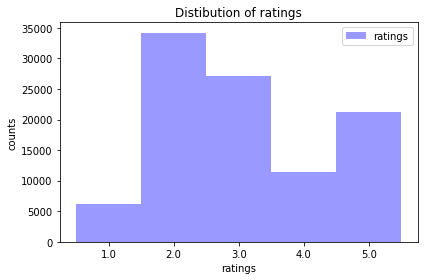

In [20]:
n_groups = 5
x = df.groupBy('rating').count().select('count')
xx = x.rdd.flatMap(lambda x: x).collect()
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 1
opacity = 0.4
rects1 = plt.bar(
    index, xx, bar_width,
    alpha=opacity,
    color='b',
    label='ratings'
)
plt.xlabel('ratings')
plt.ylabel('counts')
plt.title('Distibution of ratings')
plt.xticks(index, ('1.0', '2.0', '3.0', '4.0', '5.0'))
plt.legend()
plt.tight_layout()

In [21]:
df.groupBy('user').count().select('count').describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|               943|
|   mean|106.04453870625663|
| stddev|100.93174276633496|
|    min|                20|
|    max|               737|
+-------+------------------+



In [22]:
df.stat.crosstab('user', 'rating').show()

+-----------+---+---+---+---+---+
|user_rating|1.0|2.0|3.0|4.0|5.0|
+-----------+---+---+---+---+---+
|        645|  2|  2| 29| 55| 34|
|        892|  2| 13| 40| 99| 72|
|         69|  2|  3| 21| 16| 23|
|        809|  2|  2|  6|  5|  5|
|        629|  1|  8| 24| 35| 53|
|        365|  5|  9| 12| 23|  9|
|        138|  0|  1|  3| 28| 19|
|        760|  4|  7| 11| 13|  6|
|        101|  3| 19| 28| 16|  1|
|        479| 24| 14| 48| 85| 31|
|        347| 20| 25| 37| 55| 62|
|        846| 10| 46| 89|154|106|
|        909|  0|  0|  5|  7| 14|
|        333|  1|  1|  5| 13|  6|
|        628|  0|  1|  1|  3| 22|
|        249|  1|  5| 31| 63| 61|
|        893|  1|  5| 28| 18|  7|
|        518|  4|  3| 28| 18| 20|
|        468|  0|  9| 31| 55| 48|
|        234| 14|103|205|126| 32|
+-----------+---+---+---+---+---+
only showing top 20 rows



In [23]:
df.groupBy('user').agg({'rating': 'mean'}).take(5)

[Row(user=26, avg(rating)=2.94392523364486),
 Row(user=29, avg(rating)=3.6470588235294117),
 Row(user=474, avg(rating)=4.08256880733945),
 Row(user=191, avg(rating)=3.6296296296296298),
 Row(user=65, avg(rating)=3.9375)]

In [24]:
df.groupBy('product').agg({'rating': 'mean'}).take(5)

[Row(product=474, avg(rating)=4.252577319587629),
 Row(product=29, avg(rating)=2.6666666666666665),
 Row(product=26, avg(rating)=3.452054794520548),
 Row(product=964, avg(rating)=3.3333333333333335),
 Row(product=1677, avg(rating)=3.0)]

#### Recommender System

**1. Modeling**

In [25]:
(training, test) = ratings.randomSplit([0.8, 0.2])

In [26]:
training.count()

80041

In [27]:
test.count()

19959

In [28]:
from pyspark.mllib.recommendation import ALS

In [29]:
# Hyper parameters
rank = 10
num_iters = 10

In [30]:
model = ALS.train(ratings, rank=rank, iterations=num_iters)

In [31]:
model

**2. Prediction**

In [32]:
testdata = test.map(lambda p: (p[0], p[1]))
type(testdata)

pyspark.rdd.PipelinedRDD

In [33]:
test.take(5)

[Rating(user=196, product=242, rating=3.0),
 Rating(user=305, product=451, rating=3.0),
 Rating(user=291, product=1042, rating=4.0),
 Rating(user=234, product=1184, rating=2.0),
 Rating(user=119, product=392, rating=4.0)]

In [34]:
testdata.take(5)

[(196, 242), (305, 451), (291, 1042), (234, 1184), (119, 392)]

In [35]:
pred_index= model.predict(196, 242)
pred_index

3.1266923761458525

In [36]:
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
type(predictions)

pyspark.rdd.PipelinedRDD

In [37]:
predictions.take(5)

[((195, 1084), 3.9594648492223037),
 ((470, 1084), 2.8005333459886366),
 ((655, 1084), 3.3542390795586763),
 ((50, 1084), 4.607142253420982),
 ((194, 1410), 2.105653093326694)]

**3. Recommendation**

In [38]:
recommend_items_to_users = model.recommendProductsForUsers(10)

In [39]:
recommend_items_to_users.count()

943

In [40]:
recommend_items_to_users.take(2)

[(451,
  (Rating(user=451, product=1425, rating=7.508888595874732),
   Rating(user=451, product=914, rating=7.474391553159032),
   Rating(user=451, product=1114, rating=7.280869734860226),
   Rating(user=451, product=1297, rating=7.248781214226375),
   Rating(user=451, product=1181, rating=7.215071153889149),
   Rating(user=451, product=834, rating=7.0180481085272195),
   Rating(user=451, product=1019, rating=6.652814814761215),
   Rating(user=451, product=374, rating=6.610301312327455),
   Rating(user=451, product=1159, rating=6.588106620118025),
   Rating(user=451, product=1439, rating=6.5785295351669015))),
 (454,
  (Rating(user=454, product=1368, rating=5.042368723539213),
   Rating(user=454, product=958, rating=4.6486378947041995),
   Rating(user=454, product=1166, rating=4.63618083404309),
   Rating(user=454, product=867, rating=4.596398451252947),
   Rating(user=454, product=1446, rating=4.472412224890203),
   Rating(user=454, product=1439, rating=4.422324637151808),
   Rating(u

**4. Evaluation**

In [45]:
rates_and_preds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
type(rates_and_preds)

pyspark.rdd.PipelinedRDD

In [48]:
rates_and_preds.take(5)

[((196, 242), (3.0, 3.1266923761458525)),
 ((305, 451), (3.0, 2.8544119969436084)),
 ((234, 1184), (2.0, 2.148122840296711)),
 ((290, 88), (4.0, 3.9417592343163577)),
 ((276, 796), (1.0, 2.5090572638540243))]

In [46]:
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1]) ** 2).mean()

In [47]:
MSE

0.48345052742935346